# Application of Fuzz Logic in Stock Trading

This notebook explores fuzzy logic in its application in stock trading. The data that was used in this notebook were historical stock price data of publicly listed compnies in the Philippines.

In [1]:
# import libraries
from re import X
import numpy as np
import pandas as pd
import ta
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt

In [2]:
# read and print sample historical stock price data
series = pd.read_csv('../Data/PH-historical-stock-price-data-csv/BPI.csv', header = 0, index_col = 'Date')
print(series)

               Close      Open      High       Low     Volume
Date                                                         
1986-02-13    0.6987    0.6987    0.6987    0.6987       60.0
1986-02-21    0.6987    0.6987    0.6987    0.6987     1000.0
1986-03-05    0.7058    0.7058    0.7058    0.7058      400.0
1986-03-06    0.7058    0.7058    0.7058    0.7058      400.0
1986-03-07    0.7058    0.7058    0.7058    0.7058      700.0
...              ...       ...       ...       ...        ...
2023-09-12  107.5000  107.0000  108.2000  106.6000  2754340.0
2023-09-13  107.8000  107.7000  108.4000  106.6000  3870140.0
2023-09-14  109.6000  108.0000  111.0000  107.1000  3222340.0
2023-09-15  110.0000  109.6000  111.0000  108.2000  9976930.0
2023-09-18  108.0000  110.0000  110.0000  108.0000  1242630.0

[7478 rows x 5 columns]


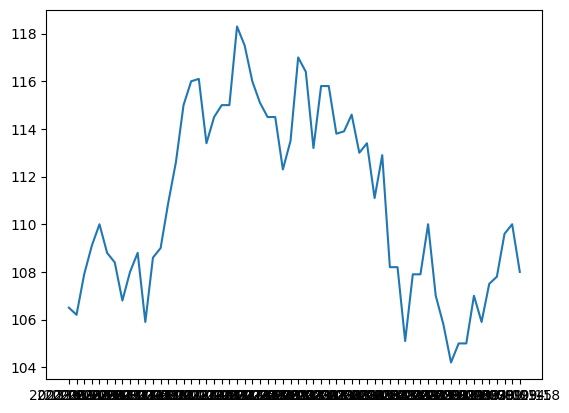

In [3]:
# plot historical stock price data
fig, ax = plt.subplots()    
ax.plot(series['Close'].tail(60))

In [4]:
def trimf(val, vector):
    """
    Triangular membership function
    
    This function calculates the fuzzy value of a crisp input
    
    a <= b <= c
    
    Args
    ----
    
    val:
        crisp value to be fuzzified
        
    vector:
        values of the left base, peak, and right of the triangular membership function
        
    Returns
    -------
        fuzzified value from the crisp value
    """
    
    
    assert len(vector) == 3, "the length of the vector must be equal to 3"
    
    a, b, c = vector
    assert a <= b, "a must be less than or equal to b"
    assert b <= c, "b must be less than or equal to c"
    
    if val <= a:
        return 0
    elif (val >= a) and (val <= b):
        return (val - a)/(b - a)
    elif (val >= b) and (val <= c):
        return (c - val)/(c - b) 
    elif val >= c:
        return 0        

In [5]:
def linearf(val, vector, positive_slope = True):
    """
    a <= b
    
    Parameters
    ----------
    
    val:
        The value to be fuzzified
        
    vector:
        A length 2 vector that defines the linear boundaries of the 
        linear membership function
    
    positive slope:

        
    Returns
    -------
        The fuzzified value from the crisp input
    """
    
    
    assert len(vector) == 2, "The vector must of of length 2"
    
    a, b = vector
    assert a<=b, "a must be less than or equal to be"
    
    if positive_slope:
       if val < a:
           return 0
       elif val > b:
           return 1
       else:
           return (val - a)/(b - a)
    else:
       if val < a:
           return 1
       elif val > b:
           return 0
       else:
           return (b - val)/(b - a) 

In [6]:
class fuzzy_TA:
    def __init__(self, df):
        self.df = df
        self.u = pd.DataFrame()
        self.z = pd.DataFrame()
        self.u_sum = pd.DataFrame()
        self.z_sum = pd.DataFrame()
    
    # MOMENTUM INDICATORS
    
    def RSI(self, window = 14, fillna = False, p0 = 0, p1 = 1):
        """
        Relative Stregth Index
    
        Parameters
        ----

        window:
            the window or number of elements to be included in the calculation
        
        p0:
            the constant to be passed in the consequent of the TSK model
        
        p1:
            the first order value to be passed in the consequent of the TSK model
        
        Returns
        ------
            None
        
        """
        
        # print(f'\n{ticker}')
        
        # compute for the RSI of the stock
        self.df[f'RSI{window}'] = (ta.momentum.RSIIndicator(
            close = self.df['Close'],
            window = window,
            fillna = fillna)
            .rsi()
        )
        
        # compute for the membership values of the RSI values
        self.u[f'RSI{window}_lo'] = self.df[f'RSI{window}'].apply(lambda x: linearf(x, [0, 50], positive_slope = False))
        self.u[f'RSI{window}_md'] = self.df[f'RSI{window}'].apply(lambda x: trimf(x, [0, 50, 100])) 
        self.u[f'RSI{window}_hi'] = self.df[f'RSI{window}'].apply(lambda x: linearf(x, [50, 100], positive_slope = True))
        
        # the following are the fuzzy rules for RSI
        # if RSI is low, then buy
        self.z[f'RSI{window}_lo'] = p0 + (p1 * ((self.u[f'RSI{window}_lo'] * 25)  + 75))
        
        # # if RSI is medium, then hold
        mask = (self.df[f'RSI{window}'] < 50)
        self.z.loc[mask, f'RSI{window}_md'] = p0 + (p1 * ((self.u[f'RSI{window}_md'] * -25) + 75))
        
        mask = (self.df[f'RSI{window}'] > 50)
        self.z.loc[mask, f'RSI{window}_md'] = p0 + (p1 * ((self.u[f'RSI{window}_md'] * 25) + 25))

        # if RSI is high then sell
        self.z[f'RSI{window}_hi'] = p0 + (p1 * ((self.u[f'RSI{window}_hi'] * -25) + 25))
        
    def StochRSI(self, window = 14, smooth1 = 3, smooth2 = 3, fillna = False, p0 = 0, p1 = 1):
        """
        Stochastic RSI
        
        Parameters
        ----------
        
        Returns
        -------
            None
        
        """
        
        self.df[f'StochRSI{window}'] = (
            ta.momentum.StochRSIIndicator(
                close = self.df['Close'],
                window = window,
                smooth1 = smooth1,
                smooth2 = smooth2,
                fillna = fillna)
            .stochrsi_d()
        )

        # calculate the membership values for low, medium and high RSI
        self.u[f'StochRSI{window}_lo'] = self.df[f'StochRSI{window}'].apply(lambda x: linearf(x, [0, 0.2], positive_slope = False))
        self.u[f'StochRSI{window}_md'] = self.df[f'StochRSI{window}'].apply(lambda x: trimf(x, [0, 0.5, 1])) 
        self.u[f'StochRSI{window}_hi'] = self.df[f'StochRSI{window}'].apply(lambda x: linearf(x, [0.8, 1], positive_slope = True))
        
        # the following are the fuzzy rules for StochRSI
        # if StochRSI is low, then buy
        self.z[f'StochRSI{window}_lo'] = p0 + (p1 * ((self.u[f'StochRSI{window}_lo'] * 25)  + 75))
        
        # if StochRSI is medium and StochRSI is less than 0.5, then buy
        mask = (self.df[f'StochRSI{window}'] < 0.5)
        self.z.loc[mask, f'StochRSI{window}_md'] = p0 + (p1 * ((self.u[f'StochRSI{window}_md'] * -25) + 75))
        
        # if StochRSI is medium and StochRSI is more than 0.5, then sell
        mask = (self.df[f'StochRSI{window}'] > 0.5)
        self.z.loc[mask, f'StochRSI{window}_md'] = p0 + (p1 * ((self.u[f'StochRSI{window}_md'] * 25) + 25))

        # if StochRSI is high then sell
        self.z[f'StochRSI{window}_hi'] = p0 + (p1 * ((self.u[f'StochRSI{window}_hi'] * -25) + 25))
        
    def WilliamsR(self, window = 14, fillna = False, p0 = 0, p1 = 1):
        """
        Compute for the williams R 
        
        Parameters
        ----------
        
        Returns
        -------
            None
        
        """
        # compute for Williams % R
        self.df[f'WilliamsR{window}'] = (
            ta.momentum.WilliamsRIndicator(
                high = self.df['High'],
                low = self.df['Low'],
                close = self.df['Close'],
                lbp = window,
                fillna = fillna)
            .williams_r()
        )

        # calculate the membership values for low, medium and high RSI
        self.u[f'WilliamsR{window}_lo'] = self.df[f'WilliamsR{window}'].apply(lambda x: linearf(x, [-100, -80], positive_slope = False))
        self.u[f'WilliamsR{window}_md'] = self.df[f'WilliamsR{window}'].apply(lambda x: trimf(x, [-100, -50, 0])) 
        self.u[f'WilliamsR{window}_hi'] = self.df[f'WilliamsR{window}'].apply(lambda x: linearf(x, [-20, 0], positive_slope = True))
        
        # the following are the fuzzy rules for StochRSI
        # if StochRSI is low, then buy
        self.z[f'WilliamsR{window}_lo'] = p0 + (p1 * ((self.u[f'WilliamsR{window}_lo'] * 25)  + 75))
        
        # if StochRSI is medium and StochRSI is less than 0.5, then buy
        mask = (self.df[f'WilliamsR{window}'] < -50)
        self.z.loc[mask, f'WilliamsR{window}_md'] = p0 + (p1 * ((self.u[f'WilliamsR{window}_md'] * -25) + 75))
        
        # if StochRSI is medium and StochRSI is more than 0.5, then sell
        mask = (self.df[f'WilliamsR{window}'] >= -50)
        self.z.loc[mask, f'WilliamsR{window}_md'] = p0 + (p1 * ((self.u[f'WilliamsR{window}_md'] * 25) + 25))

        # if StochRSI is high then sell
        self.z[f'WilliamsR{window}_hi'] = p0 + (p1 * ((self.u[f'WilliamsR{window}_hi'] * -25) + 25))

    def Ultimate(self, window1 = 7, window2 = 14, window3 = 28, weight1 = 4.0, weight2 = 2.0, weight3 = 1.0, fillna = False, p0 = 0, p1 = 1):
        """
        Ultiimate oscilator
        
        Parameters
        ----------
        
        Returns
        -------
            None
        
        """
        
        # compute for the Ultimate oscillator
        self.df[f'Ultimate{window1}'] = ta.momentum.ultimate_oscillator(
            high = self.df['High'], 
            low = self.df['Low'], 
            close = self.df['Close'], 
            window1 = window1, 
            window2 = window2, 
            window3 = window3, 
            weight1 = weight1, 
            weight2 = weight2, 
            weight3 = weight3, 
            fillna = fillna)
    
        # calculate the membership values for low, medium and high ultimate oscillator
        self.u[f'Ultimate{window1}_lo'] = self.df[f'Ultimate{window1}'].apply(lambda x: linearf(x, [0, 20], positive_slope = False))
        self.u[f'Ultimate{window1}_md'] = self.df[f'Ultimate{window1}'].apply(lambda x: trimf(x, [0, 50, 100])) 
        self.u[f'Ultimate{window1}_hi'] = self.df[f'Ultimate{window1}'].apply(lambda x: linearf(x, [80, 100], positive_slope = True))
        
        # the following are the fuzzy rules for ultimate oscillator
        # if ultimate is low, then buy
        self.z[f'Ultimate{window1}_lo'] = p0 + (p1 * ((self.u[f'Ultimate{window1}_lo'] * 25)  + 75))
        
        # if ultimate is medium and ultimate is below 50 then do this; borderlining to buying
        mask = (self.df[f'Ultimate{window1}'] < 50)
        self.z.loc[mask, f'Ultimate{window1}_md'] = p0 + (p1 * ((self.u[f'Ultimate{window1}_md'] * -25) + 75))
        
        # if ultimate is medium and ultimate is above or equal to  50 then do this; borderlining to selling
        mask = (self.df[f'Ultimate{window1}'] >= 50)
        self.z.loc[mask, f'Ultimate{window1}_md'] = p0 + (p1 * ((self.u[f'Ultimate{window1}_md'] * 25) + 25))

        # if ultimate is high then sell
        self.z[f'Ultimate{window1}_hi'] = p0 + (p1 * ((self.u[f'Ultimate{window1}_hi'] * -25) + 25))

    def TSI(self, window_slow = 25, window_fast = 13, fillna= False, p0 = 0, p1 = 1):
        """
        True Strength Index
        
        Parameters
        ----------
        window_slow:

        window_fast:
        
        fillna:
        
        Returns
        -------        
            None
        """

        # compute for the TSI of the stock
        self.df[f'TSI{window_slow}x{window_fast}'] = (ta.momentum.tsi(
            close = self.df['Close'],
            window_slow = 25,
            window_fast = 13,
            fillna = False)
        )

        # calculate the membership values for low, medium and high ultimate oscillator
        self.u[f'TSI{window_slow}x{window_fast}_lo'] = self.df[f'TSI{window_slow}x{window_fast}'].apply(lambda x: linearf(x, [-0.5, -0.25], positive_slope = False))
        self.u[f'TSI{window_slow}x{window_fast}_md'] = self.df[f'TSI{window_slow}x{window_fast}'].apply(lambda x: trimf(x, [-0.5, 0, 0.5])) 
        self.u[f'TSI{window_slow}x{window_fast}_hi'] = self.df[f'TSI{window_slow}x{window_fast}'].apply(lambda x: linearf(x, [0.25, 0.5], positive_slope = True))


        # the following are the fuzzy rules for ultimate oscillator
        # if TSI is low, then buy
        self.z[f'TSI{window_slow}x{window_fast}_lo'] = p0 + (p1 * ((self.u[f'TSI{window_slow}x{window_fast}_lo'] * 25)  + 75))
        
        # if TSI is medium, then hold
        self.z[f'TSI{window_slow}x{window_fast}_md'] = p0 + (p1 * (50))

        # if TSI is high then sell
        self.z[f'TSI{window_slow}x{window_fast}_hi'] = p0 + (p1 * ((self.u[f'TSI{window_slow}x{window_fast}_hi'] * -25) + 25))


    # VOLUME INDICATORS

    def CMF(self, window = 20, fillna = False, weekly = False, monthly = False, p0 = 0, p1 = 1):
        """
        Chaikin Money Flow
        
        Parameters
        ----------
        
        Returns
        -------
        None
        
        
        """
        
        
        self.df[f'CMF{window}'] = (
            ta.volume.chaikin_money_flow(
                high = self.df['High'], 
                low = self.df['Low'], 
                close = self.df['Close'], 
                volume = self.df['Volume'], 
                window = window, 
                fillna = fillna)
            )

        CMF_val = self.df[f'CMF{window}'].iloc[-1]
        
        # calculate the membership values for low, medium and high CMF
        self.u[f'CMF{window}_lo'] = self.df[f'CMF{window}'].apply(lambda x: linearf(x, [-1, 0], positive_slope = False))
        self.u[f'CMF{window}_md'] = self.df[f'CMF{window}'].apply(lambda x: trimf(x, [-1, 0, 1])) 
        self.u[f'CMF{window}_hi'] = self.df[f'CMF{window}'].apply(lambda x: linearf(x, [0, 1], positive_slope = True))        
        
        # the following are the fuzzy rules for CMF
        # if CMF_val is negative then buy
        self.z[f'CMF{window}_lo'] = p0 + (p1 * ((self.u[f'CMF{window}_lo'] * 25)  + 75))
        
        # if CMF is medium and ultimate is below 0 then do this; borderlining to buying
        mask = (self.df[f'CMF{window}'] < 0)
        self.z.loc[mask, f'CMF{window}_md'] = p0 + (p1 * ((self.u[f'CMF{window}_md'] * -25) + 75))
        
        # if CMF is medium and ultimate is above or equal to  0 then do this; borderlining to selling
        mask = (self.df[f'CMF{window}'] >= 0)
        self.z.loc[mask, f'CMF{window}_md'] = p0 + (p1 * ((self.u[f'CMF{window}_md'] * 25) + 25))

        # if CMF is high then sell
        self.z[f'CMF{window}_hi'] = p0 + (p1 * ((self.u[f'CMF{window}_hi'] * -25) + 25))
        
    def MFI(self, window = 14, fillna = False, weekly = False, monthly = False, p0 = 0, p1 = 1):
        """
        Money Flow Index
        
        Parameters
        ----------
        
        Returns
        -------
        None
        
        
        """
        # calculate the money flow index for the window
        self.df[f'MFI{window}'] = (
            ta.volume.MFIIndicator(
                high = self.df['High'], 
                low = self.df['Low'], 
                close = self.df['Close'], 
                volume = self.df['Volume'], 
                window = window, 
                fillna = fillna)
            .money_flow_index()
        )
        
        # calculate the membership values for low, medium and high MFI
        self.u[f'MFI{window}_lo'] = self.df[f'MFI{window}'].apply(lambda x: linearf(x, [0, 20], positive_slope = False))
        self.u[f'MFI{window}_md'] = self.df[f'MFI{window}'].apply(lambda x: trimf(x, [0, 50, 100])) 
        self.u[f'MFI{window}_hi'] = self.df[f'MFI{window}'].apply(lambda x: linearf(x, [80, 100], positive_slope = True))


        # the following are the fuzzy rules for MFI
        # if CMF_val is negative then buy
        self.z[f'MFI{window}_lo'] = p0 + (p1 * ((self.u[f'MFI{window}_lo'] * 25)  + 75))
        
        # if CMF is medium and ultimate is below 0 then do this; borderlining to buying
        mask = (self.df[f'MFI{window}'] < 0)
        self.z.loc[mask, f'MFI{window}_md'] = p0 + (p1 * ((self.u[f'MFI{window}_md'] * -25) + 75))
        
        # if CMF is medium and ultimate is above or equal to  0 then do this; borderlining to selling
        mask = (self.df[f'MFI{window}'] >= 0)
        self.z.loc[mask, f'MFI{window}_md'] = p0 + (p1 * ((self.u[f'MFI{window}_md'] * 25) + 25))

        # if CMF is high then sell
        self.z[f'MFI{window}_hi'] = p0 + (p1 * ((self.u[f'MFI{window}_hi'] * -25) + 25))
            
    def RSI_OBV(self, window = 14, fillna = False, weekly = False, monthly = False, p0 = 0, p1 = 1):
        """
        Relative Stregth Index as applied on the On Balance Volume
        
    
        Parameters
        ----
        window:
            The window 
        
        p0:
            The constant to be passed in the consequent of the TSK model
        
        p1:
            The first order value to be passed in the consequent of the TSK model
        
        Returns
        ------
            None
        
        """

        # compute for OBV
        self.df['OBV'] = (
            ta.volume.OnBalanceVolumeIndicator(
                close = self.df['Close'], 
                volume = self.df['Volume'], 
                fillna = False)
            .on_balance_volume()
        )

        # normalize OBV
        volume_sum = self.df['OBV'].sum()
        self.df['OBV'] = (self.df['OBV']/volume_sum)*100

        # compute for the RSI of the stock
        self.df[f'RSI_OBV{window}'] = (
            ta.momentum.RSIIndicator(
                close = self.df['OBV'], 
                window = window, 
                fillna = fillna)
            .rsi()
        )
        
        # calculate the membership values for low, medium and high RSI_OBV
        self.u[f'RSI_OBV{window}_lo'] = self.df[f'RSI_OBV{window}'].apply(lambda x: linearf(x, [0, 20], positive_slope = False))
        self.u[f'RSI_OBV{window}_md'] = self.df[f'RSI_OBV{window}'].apply(lambda x: trimf(x, [0, 50, 100])) 
        self.u[f'RSI_OBV{window}_hi'] = self.df[f'RSI_OBV{window}'].apply(lambda x: linearf(x, [80, 100], positive_slope = True))
        
        # the following are the fuzzy rules for RSI_OBV
        # if RSI_OBV is low then buy
        self.z[f'RSI_OBV{window}_lo'] = p0 + (p1 * ((self.u[f'RSI_OBV{window}_lo'] * 25)  + 75))
        
        # if RSI_OBV is medium and RSI_OBV is below 50 then do this; borderlining to buying
        mask = (self.df[f'RSI_OBV{window}'] < 50)
        self.z.loc[mask, f'RSI_OBV{window}_md'] = p0 + (p1 * ((self.u[f'RSI_OBV{window}_md'] * -25) + 75))
        
        # if RSI_OBV is medium and RSI_OBV is above or equal to  50 then do this; borderlining to selling
        mask = (self.df[f'RSI_OBV{window}'] >= 50)
        self.z.loc[mask, f'RSI_OBV{window}_md'] = p0 + (p1 * ((self.u[f'RSI_OBV{window}_md'] * 25) + 25))

        # if RSI_OBV is high then sell
        self.z[f'RSI_OBV{window}_hi'] = p0 + (p1 * ((self.u[f'RSI_OBV{window}_hi'] * -25) + 25))
        
    # VOLATILITY INDICATORS
    def BB_pband(self, window = 20, window_dev = 2, fillna = False, weekly = False, monthly = False, p0 = 0, p1 = 1):
        """
        Bolinger percentage band
        
        Parameters
        ----------
        
        Returns
        -------
            None
        
        """
        
        self.df[f'BB_pband{window}'] = (ta.volatility.bollinger_pband(
            close = self.df['Close'], 
            window = window, 
            window_dev = window_dev, 
            fillna = fillna)
        )

        
        # calculate the membership values for low, medium and high RSI
        self.u[f'BB_pband{window}_lo'] = self.df[f'BB_pband{window}'].apply(lambda x: linearf(x, [-0.2, 0], positive_slope = False))
        self.u[f'BB_pband{window}_md'] = self.df[f'BB_pband{window}'].apply(lambda x: trimf(x, [0, 0.5, 1])) 
        self.u[f'BB_pband{window}_hi'] = self.df[f'BB_pband{window}'].apply(lambda x: linearf(x, [1, 1.2], positive_slope = True))
        

        # the following are the fuzzy rules for BB_pband
        # if BB_pband is low then buy
        self.z[f'BB_pband{window}_lo'] = p0 + (p1 * ((self.u[f'BB_pband{window}_lo'] * 25) + 75))
        
        # if BB_pband is low
        mask = self.df[f'BB_pband{window}'] < 0
        # if BB_pband is less than 0, then lean towards buying
        self.z.loc[mask, f'BB_pband{window}_md'] = p0 + (p1 * ((self.u[f'BB_pband{window}_md'] * -25) + 75))

        mask = self.df[f'BB_pband{window}'] >= 0
        # if BB_pband is greater than or equal to  0, then lean towards selling
        self.z.loc[mask, f'BB_pband{window}_md'] = p0 + (p1 * ((self.u[f'BB_pband{window}_md'] * 25) + 25))

        # if BB_pband is high then sell
        self.z[f'BB_pband{window}_hi'] = p0 + (p1 * ((self.u[f'BB_pband{window}_hi'] * -25) + 25))
        
    # TREND INDICATORS
    
    def CCI(self, window = 20, constant = 0.0015, fillna = False, weekly = False, monthly = False, p0 = 0, p1 = 1):
        """
        Compute for the commodity channel index
        """
        # compute for the commodity channel index
        self.df[f'CCI{window}'] = (
            ta.trend.CCIIndicator(
                high = self.df['High'],
                low = self.df['Low'],
                close = self.df['Close'],
                window = window,
                constant = constant,
                fillna = fillna)
            .cci()
        )

    
        # calculate the membership values for low, medium and high CCI
        self.u[f'CCI{window}_lo'] = self.df[f'CCI{window}'].apply(lambda x: linearf(x, [-200, -100], positive_slope = False))
        self.u[f'CCI{window}_md'] = self.df[f'CCI{window}'].apply(lambda x: trimf(x, [-200, 0, 200])) 
        self.u[f'CCI{window}_hi'] = self.df[f'CCI{window}'].apply(lambda x: linearf(x, [100, 200], positive_slope = True))
        
        # the following are the fuzzy rules for CCI
        # if BB_pband is low then buy
        self.z[f'CCI{window}_lo'] = p0 + (p1 * ((self.u[f'CCI{window}_lo'] * 25) + 75))
        
        # if CCI is low
        mask = self.df[f'CCI{window}'] < 0
        # if CCI is less than 0, then lean towards buying
        self.z.loc[mask, f'CCI{window}_md'] = p0 + (p1 * ((self.u[f'CCI{window}_md'] * -25) + 75))

        mask = self.df[f'CCI{window}'] >= 0
        # if CCI is greater than or equal to  0, then lean towards selling
        self.z.loc[mask, f'CCI{window}_md'] = p0 + (p1 * ((self.u[f'CCI{window}_md'] * 25) + 25))

        # if CCI is high then sell
        self.z[f'CCI{window}_hi'] = p0 + (p1 * ((self.u[f'CCI{window}_hi'] * -25) + 25))
    
    def STC(self, window_slow = 50, window_fast = 30, cycle = 30, smooth1 = 3, smooth2 = 3, fillna = False, weekly = False, monthly = False, p0 = 0, p1 = 1, ticker = 'ticker'):
        """
        Schaff Trend Cycle
        
        Parameters
        ----------
        
        Returns
        -------
            None
        
        """
        
        self.df[f'STC{window_slow}'] = (
            ta.trend.STCIndicator(
                close = self.df['Close'],
                window_slow = window_slow,
                window_fast = window_fast,
                cycle = cycle,
                smooth1 = smooth1,
                smooth2 = smooth2,
                fillna = fillna)
            .stc()
        )
        
        # calculate the membership values for low, medium and high CCI
        self.u[f'STC{window_slow}_lo'] = self.df[f'STC{window_slow}'].apply(lambda x: linearf(x, [0, 20], positive_slope = False))
        self.u[f'STC{window_slow}_md'] = self.df[f'STC{window_slow}'].apply(lambda x: trimf(x, [0, 50, 100])) 
        self.u[f'STC{window_slow}_hi'] = self.df[f'STC{window_slow}'].apply(lambda x: linearf(x, [80, 100], positive_slope = True))
        
        # the following are the fuzzy rules for CCI
        # if BB_pband is low then buy
        self.z[f'STC{window_slow}_lo'] = p0 + (p1 * ((self.u[f'STC{window_slow}_lo'] * 25) + 75))
        
        # if CCI is low
        mask = self.df[f'STC{window_slow}'] < 50
        # if CCI is less than 0, then lean towards buying
        self.z.loc[mask, f'STC{window_slow}_md'] = p0 + (p1 * ((self.u[f'STC{window_slow}_md'] * -25) + 75))

        mask = self.df[f'STC{window_slow}'] >= 50
        # if CCI is greater than or equal to  0, then lean towards selling
        self.z.loc[mask, f'STC{window_slow}_md'] = p0 + (p1 * ((self.u[f'STC{window_slow}_md'] * 25) + 25))

        # if CCI is high then sell
        self.z[f'STC{window_slow}_hi'] = p0 + (p1 * ((self.u[f'STC{window_slow}_hi'] * -25) + 25))
        
    def PSAR(self, step = 0.02, max_step = 0.2, fillna = False, weekly = False, monthly = False, p0 = 0, p1 = 1):
        """
        Parabolic SAR
        
        Parameters
        ----------
        
        step:   float
            lorem ipsum
            
        max_step:   float
            lorem ipsum
            
        fillna: bool
            lorem ipsum
        
        p0: float
            lorem ipsum
        
        p1: float
            lorem ipsum
        
        Returns
        -------
        None
        """
        
        # parabolic SAR
        self.df[f'PSAR{step}{max_step}'] = (ta.trend.PSARIndicator(
            high = self.df['High'],
            low = self.df['Low'],
            close = self.df['Close'],
            step = step,
            max_step = max_step,
            fillna = fillna)
            .psar()
        )
        
        # conditions for buy
        condition_1 = self.df[f'PSAR{step}{max_step}'].iloc[-2] > self.df['Close'].iloc[-2]
        condition_2 = self.df[f'PSAR{step}{max_step}'].iloc[-1] < self.df['Close'].iloc[-1]
         
        if condition_1 & condition_2:
            self.u[f'PSAR{step}{max_step}_buy'] = 1
            self.z[f'PSAR{step}{max_step}_buy'] = 100
        elif (not condition_1) & (not condition_2):
            self.u[f'PSAR{step}{max_step}_sell'] = 1
            self.z[f'PSAR{step}{max_step}_sell'] = 0
        else:
            self.u[f'PSAR{step}{max_step}_hold'] = 1
            self.z[f'PSAR{step}{max_step}_hold'] = 50 

    # OTHER INDICATORS
    
    def Fisher_trans(self, window: int = 14, smooth2: int = 3, adjust: bool = True, weekly = False, monthly = False, p0 = 0, p1 = 1):
        """
        Fisher Transform
        
        Parameters
        ----------
        
        Returns
        -------
            None
        
        
        """
        
        np.seterr(divide='ignore')

        med = (self.df['High'] + self.df['Low']) / 2
        ndaylow = med.rolling(window=window).min()
        ndayhigh = med.rolling(window=window).max()
        raw = (2 * ((med - ndaylow) / (ndayhigh - ndaylow))) - 1
        smooth = raw.ewm(span=5, adjust=adjust).mean()
        _smooth = smooth.fillna(0)
        
        self.df[f'Fisher{window}'] = (
            (np.log((1 + _smooth) / (1 - _smooth)))
            .ewm(span=3, adjust=adjust)
            .mean()
        )
        
        # calculate the membership values for low, medium and high Fisher
        self.u[f'Fisher{window}_lo'] = self.df[f'Fisher{window}'].apply(lambda x: linearf(x, [-4, 0], positive_slope = False))
        self.u[f'Fisher{window}_md'] = self.df[f'Fisher{window}'].apply(lambda x: trimf(x, [-2, 0, 2])) 
        self.u[f'Fisher{window}_hi'] = self.df[f'Fisher{window}'].apply(lambda x: linearf(x, [0, 4], positive_slope = True))
        
        # the following are the fuzzy rules for Fisher
        # if Fisher is low, then buy
        self.z[f'Fisher{window}_lo'] = p0 + (p1 * ((self.u[f'Fisher{window}_lo'] * 25)  + 75))
        
        # if Fisher is medium and Fisher is less than 0.5, then buy
        mask = (self.df[f'StochRSI{window}'] < 0)
        self.z.loc[mask, f'Fisher{window}_md'] = p0 + (p1 * ((self.u[f'Fisher{window}_md'] * -25) + 75))
        
        # if Fisher is medium and Fisher is more than 0.5, then sell
        mask = (self.df[f'StochRSI{window}'] >= 0)
        self.z.loc[mask, f'Fisher{window}_md'] = p0 + (p1 * ((self.u[f'Fisher{window}_md'] * 25) + 25))

        # if Fisher is high then sell
        self.z[f'Fisher{window}_hi'] = p0 + (p1 * ((self.u[f'Fisher{window}_hi'] * -25) + 25))
    
    def z_total(self):
        """
        Computes for the total z value for the consequent of the Tsukamoto model
        
        Parameters
        ----------
        
        self
        
        Returns
        -------
        z_total
            the consequent in the Takagi-Sugeno-Kang/Tsukamoto fuzzy inference model
        
        """
        
        self.u_sum['sum'] = self.u.sum(axis = 1)
        
        # initialize z_sum to be 0
        self.z['z_sum'] = 0
        
        # add all values of z across different technical indicator
        for col_name in self.u.columns:
            # produce mask that would remove NANs in the dataframe
            mask = ~(self.z['z_sum'] + (self.z[f'{col_name}'] * self.u[f'{col_name}'])).isna()
            # apply mask
            self.z.loc[mask, 'z_sum'] = self.z['z_sum'] + (self.z[f'{col_name}'] * self.u[f'{col_name}'])
        
        # compute for the normalized z_sum by u_sum
        self.df['z_sum'] = self.z['z_sum'] / self.u_sum['sum']
            
        return 0
    

In [7]:
stock = fuzzy_TA(series)

# momentum indicators
stock.RSI()
stock.StochRSI()
stock.WilliamsR()
stock.Ultimate()
stock.TSI()

# volume indicator
stock.CMF()
stock.MFI()
stock.RSI_OBV()

# volatility indicator
stock.BB_pband()

# trend indicators
stock.CCI()
stock.STC()
stock.PSAR()

# other indicator
stock.Fisher_trans()

# # momentum indicators
# stock.RSI(window = 260)
# stock.StochRSI(window = 260)
# # stock.WilliamsR(window = 260)
# # stock.Ultimate()
# # stock.TSI()

# # volume indicator
# stock.CMF(window = 260)
# # stock.MFI(window = 260)
# # stock.RSI_OBV(window = 260)

# # volatility indicator
# stock.BB_pband(window = 260)

# # trend indicators
# stock.CCI(window = 260)
# # stock.STC()
# # stock.PSAR()

# # other indicator
# stock.Fisher_trans(window = 260)



# compute for the total value of z
stock.z_total()
stock.df['z_sum_rolling']=stock.df['z_sum'].rolling(7).mean()
stock.df['z_sum_ewm'] = stock.df['z_sum'].ewm(span=7).mean()
print(stock.df[['z_sum', 'z_sum_rolling', 'z_sum_ewm']].tail(60))



                z_sum  z_sum_rolling  z_sum_ewm
Date                                           
2023-06-22  27.888184      32.344345  33.109849
2023-06-23  28.564480      29.771752  31.973507
2023-06-26  24.397103      27.204877  30.079406
2023-06-27  21.618587      26.609783  27.964201
2023-06-29  21.275020      25.685866  26.291906
2023-06-30  22.673585      24.533440  25.387326
2023-07-03  24.875668      24.470375  25.259411
2023-07-04  29.448832      24.693325  26.306767
2023-07-05  28.195520      24.640617  26.778955
2023-07-06  27.179302      25.038073  26.879042
2023-07-07  35.757454      27.057912  29.098645
2023-07-10  29.871173      28.285933  29.291777
2023-07-11  28.416809      29.106394  29.073035
2023-07-12  24.391566      29.037237  27.902668
2023-07-13  23.731840      28.220523  26.859961
2023-07-14  16.986700      26.619263  24.391646
2023-07-17  18.706014      25.408794  22.970238
2023-07-18  18.134824      22.891275  21.761384
2023-07-19  22.887062      21.893545  22

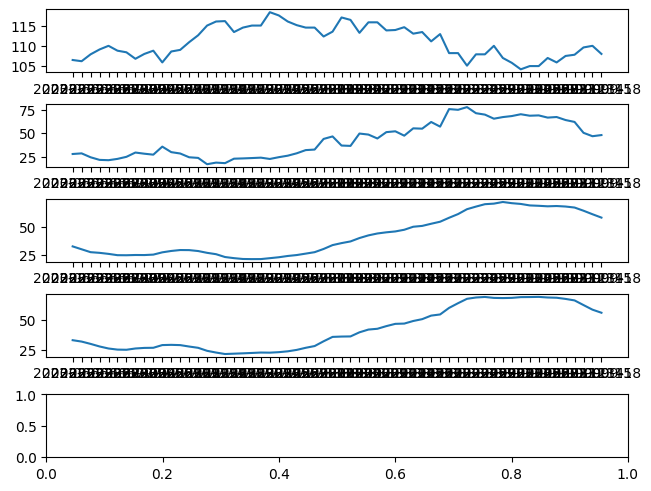

In [8]:
fig, axs = plt.subplots(5, 1, layout='constrained')
axs[0].plot(series['Close'].tail(60))
axs[1].plot(stock.df['z_sum'].tail(60))
axs[2].plot(stock.df['z_sum_rolling'].tail(60))
axs[3].plot(stock.df['z_sum_ewm'].tail(60))

plt.show()

In [9]:
# split a univariate dataset into train-test sets
def train_test_split(data, n_test):
    return data[:-n_test], data[-n_test:]

In [10]:
# # establish regime
# stock.df['regime'] = 0
# z = 1

# for i in range(0, len(stock.df)-1):
#     if stock.df['z_sum_rolling'][i] >= 80 and z == 1:
#         stock.df['regime'][i+1] = 1
#         z = 0
#     elif stock.df['RSI260'][i] >= 50 and z == 0:
#         stock.df['regime'][i] = -1
#         z = 1
        
# for i in range(1, len(stock.df)):
#     if stock.df['regime'][i-1] == 1 and stock.df['regime'][i] == 0:
#         stock.df['regime'][i] = 1
        
# stock.df['returns'] = 1
# stock.df['change'] = stock.df['Close'].pct_change()+1

# for i in range(0, len(stock.df)):
#     if stock.df['regime'][i] != 0:
#         stock.df['returns'][i] = stock.df['change'][i]
        
# # stock.df['change'].cumprod().tail(500).plot(label = 'Buy and hold')
# # stock.df['returns'].cumprod().tail(500).plot(label = 'Fuzzy Logic').legend()

# stock.df['change'].cumprod().plot(label = 'Buy and hold')
# stock.df['returns'].cumprod().plot(label = 'Fuzzy Logic').legend()

# print(stock.df['change'].cumprod().iloc[-1], stock.df['returns'].cumprod().iloc[-1])

False 		 nan 		 0 		 0.6987 		 inf
False 		 nan 		 0 		 0.6987 		 inf
False 		 nan 		 0 		 0.7058 		 inf
False 		 nan 		 0 		 0.7058 		 inf
False 		 nan 		 0 		 0.7058 		 inf
False 		 nan 		 0 		 0.7728 		 inf
False 		 25.0 		 0 		 0.7411 		 inf
False 		 25.0 		 0 		 0.8116 		 inf
False 		 25.0 		 0 		 0.794 		 inf
False 		 25.0 		 0 		 0.8704 		 inf
False 		 25.0 		 0 		 0.9175 		 inf
False 		 25.0 		 0 		 0.988 		 inf
False 		 25.0 		 0 		 1.0351 		 inf
False 		 25.673772329512186 		 0 		 0.988 		 inf
False 		 25.65839376359995 		 0 		 1.0351 		 inf
False 		 25.376563816804122 		 0 		 1.0586 		 inf
False 		 24.880162238224802 		 0 		 1.0586 		 inf
False 		 24.172293925702494 		 0 		 1.0821 		 inf
False 		 24.6226617701134 		 0 		 1.0586 		 inf
False 		 24.46246770375462 		 0 		 1.0586 		 inf
False 		 23.274877526156967 		 0 		 1.1057 		 inf
False 		 23.0348318282469 		 0 		 1.1057 		 inf
False 		 22.559831149212847 		 0 		 1.1762 		 inf
False 		 22.856996568680987 		 0 		 1.2233 		 i

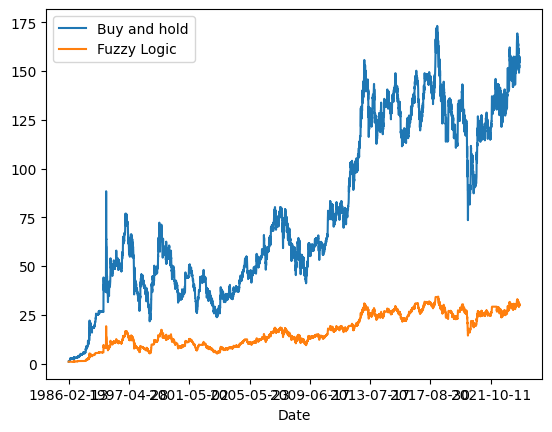

In [11]:
stock.df['returns'] = 1
stock.df['change'] = stock.df['Close'].pct_change()+1
stock.df['regime'] = 0
has_long_position = False
buy_price = 0
buy_index = 0
for i in range(0, len(stock.df)-1):
    if (stock.df['z_sum_rolling'][i] >= 50) and has_long_position == False:
        print(stock.df['z_sum_rolling'][i], i)
        # buy stock in the next day
        stock.df['regime'][i+1] = 1
        buy_price = stock.df['Close'][i+1]
        has_long_position = True
    
    condition1 = (100*(stock.df['Close'][i] - buy_price)/buy_price) < - 5
    condition2 = stock.df['z_sum_rolling'][i] <= 20
    if ( (condition1) or (condition2) ) and has_long_position == True:
        stock.df['regime'][i] = -1
        # buy_price = 0
        has_long_position = False
    print(stock.df['z_sum_rolling'][i]>50,'\t\t', stock.df['z_sum_rolling'][i],'\t\t',stock.df['regime'][i],'\t\t',stock.df['Close'][i],'\t\t', 100*(stock.df['Close'][i] - buy_price)/buy_price)   
for i in range(1, len(stock.df)):
    if stock.df['regime'][i-1] == 1 and stock.df['regime'][i] == 0:
        stock.df['regime'][i] = 1

for i in range(0, len(stock.df)):
    if stock.df['regime'][i] != 0:
        stock.df['returns'][i] = stock.df['change'][i]
        
stock.df['change'].cumprod().plot(label = 'Buy and hold')
stock.df['returns'].cumprod().plot(label = 'Fuzzy Logic').legend()

# print(stock.df['change'].cumprod().iloc[-1], stock.df['returns'].cumprod().iloc[-1])


# for i in range(1, len(stock.df)):
#     stock.df['change'][i] = 100*(stock.df['Close'][i-1] - stock.df['Close'][i])/stock.df['Close'][i-1]
# print(stock.df[['Close','z_sum_rolling', 'change']].tail(20))

In [12]:
print(stock.df[['Close','z_sum_rolling', 'change', 'regime']].tail(20))

            Close  z_sum_rolling    change  regime
Date                                              
2023-08-18  111.1      52.480230  0.979718       1
2023-08-22  112.9      54.285204  1.016202       1
2023-08-23  108.2      57.797009  0.958370       1
2023-08-24  108.2      61.069969  1.000000       1
2023-08-25  105.1      65.425810  0.971349       1
2023-08-29  107.9      67.734175  1.026641       1
2023-08-30  107.9      69.875201  1.000000       1
2023-08-31  110.0      70.376220  1.019462       1
2023-09-01  107.0      71.831656  0.972727       1
2023-09-04  105.8      70.770171  0.988785       1
2023-09-05  104.2      70.095847  0.984877       1
2023-09-06  105.0      68.781914  1.007678       1
2023-09-07  105.0      68.444862  1.000000       1
2023-09-08  107.0      67.990504  1.019048       1
2023-09-11  105.9      68.245771  0.989720       1
2023-09-12  107.5      67.793771  1.015109       1
2023-09-13  107.8      66.899208  1.002791       1
2023-09-14  109.6      64.06837

In [13]:
stock.df['returns'] = 1

for i in range(1, len(stock.df)):
    stock.df['change'][i] = 100*(stock.df['Close'][i-1] - stock.df['Close'][i])/stock.df['Close'][i-1]
print(stock.df[['Close','z_sum_rolling', 'change']].tail(20))

pct_change = 0
for i in range(1, 20):
    pct_change += stock.df['change'][-i]
    # print(stock.df['change'][-i])
print(pct_change)


            Close  z_sum_rolling    change
Date                                      
2023-08-18  111.1      52.480230  2.028219
2023-08-22  112.9      54.285204 -1.620162
2023-08-23  108.2      57.797009  4.162976
2023-08-24  108.2      61.069969  0.000000
2023-08-25  105.1      65.425810  2.865065
2023-08-29  107.9      67.734175 -2.664129
2023-08-30  107.9      69.875201  0.000000
2023-08-31  110.0      70.376220 -1.946247
2023-09-01  107.0      71.831656  2.727273
2023-09-04  105.8      70.770171  1.121495
2023-09-05  104.2      70.095847  1.512287
2023-09-06  105.0      68.781914 -0.767754
2023-09-07  105.0      68.444862  0.000000
2023-09-08  107.0      67.990504 -1.904762
2023-09-11  105.9      68.245771  1.028037
2023-09-12  107.5      67.793771 -1.510859
2023-09-13  107.8      66.899208 -0.279070
2023-09-14  109.6      64.068373 -1.669759
2023-09-15  110.0      60.944176 -0.364964
2023-09-18  108.0      57.947722  1.818182
2.507609820721475


In [14]:
print(stock.df['change'][-19:].sum())

# stock.df['change']

2.5076098207214748


In [15]:
stock.df['returns'] = 1
stock.df['change'] = stock.df['Close'].pct_change()+1

# establish regime
stock.df['regime'] = 0
z = 1

stock.df['highest'] = stock.df['Close'].cummax()
stock.df['trailingstop'] = stock.df['highest']*0.95

buy_price = 0
buy_index = 0
for i in range(0, len(stock.df)-1):
    if stock.df['z_sum_rolling'][i] >= 60 and z == 1:
        stock.df['regime'][i+1] = 1
        buy_price = stock.df['Close'][i+1]
        buy_index = i+1
        z = 0
    if stock.df['Close'][buy_index] < stock.df['change'].iloc[buy_index+1, i].sum() and z == 0:
        stock.df['regime'][i] = -1
        z = 1
        
for i in range(1, len(stock.df)):
    if stock.df['regime'][i-1] == 1 and stock.df['regime'][i] == 0:
        stock.df['regime'][i] = 1

for i in range(0, len(stock.df)):
    if stock.df['regime'][i] != 0:
        stock.df['returns'][i] = stock.df['change'][i]
        
# stock.df['change'].cumprod().tail(500).plot(label = 'Buy and hold')
# stock.df['returns'].cumprod().tail(500).plot(label = 'Fuzzy Logic').legend()

stock.df['change'].cumprod().plot(label = 'Buy and hold')
stock.df['returns'].cumprod().plot(label = 'Fuzzy Logic').legend()

print(stock.df['change'].cumprod().iloc[-1], stock.df['returns'].cumprod().iloc[-1])

IndexingError: Too many indexers

36.964417730063346 31.94444444444412


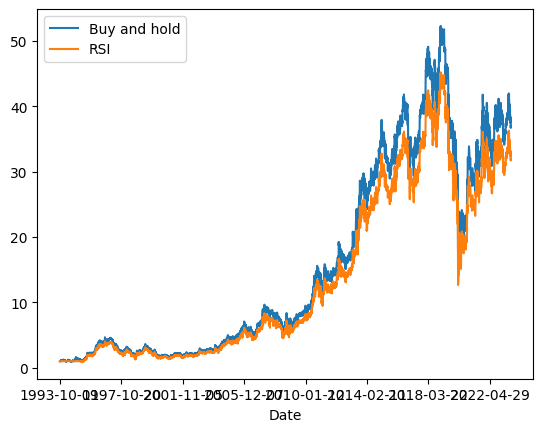

In [ ]:
# establish regime
stock.df['regime'] = 0
z = 1

stock.df['highest'] = stock.df['Close'].cummax()
stock.df['trailingstop'] = stock.df['highest']*0.95

for i in range(0, len(stock.df)-1):
    if stock.df['RSI260'][i] <= 50 and z == 1:
        stock.df['regime'][i+1] = 1
        z = 0
    if stock.df['Close'][i] < stock.df['trailingstop'][i] and z == 0:
        stock.df['regime'][i] = -1
        z = 1
        
for i in range(1, len(stock.df)):
    if stock.df['regime'][i-1] == 1 and stock.df['regime'][i] == 0:
        stock.df['regime'][i] = 1
        
stock.df['returns'] = 1
stock.df['change'] = stock.df['Close'].pct_change()+1

for i in range(0, len(stock.df)):
    if stock.df['regime'][i] != 0:
        stock.df['returns'][i] = stock.df['change'][i]

stock.df['change'].cumprod().plot(label = 'Buy and hold')
stock.df['returns'].cumprod().plot(label = 'RSI').legend()

print(stock.df['change'].cumprod().iloc[-1], stock.df['returns'].cumprod().iloc[-1])

In [ ]:
print(stock.df[['Close','regime']].tail(100))

            Close  regime
Date                     
2023-04-25  220.0       0
2023-04-26  219.2       0
2023-04-27  219.0       0
2023-04-28  225.0       0
2023-05-02  225.6       0
...           ...     ...
2023-09-12  238.0       0
2023-09-13  230.0       0
2023-09-14  232.4       0
2023-09-15  228.2       0
2023-09-18  230.0       0

[100 rows x 2 columns]
